In [1]:
import sys
import os
from datetime import datetime
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ml_models.anomaly_detector import AnomalyDetector

sns.set_palette("husl")
plt.style.use("seaborn-v0_8")

DATA_DIR = "../data/processed"
MODELS_DIR = "../data/models"
MODEL_NAME = "anomaly_detector_v2.joblib"
os.makedirs(MODELS_DIR, exist_ok=True)

print("="*72)
print("JUNTA ANALYTICS")
print(f"Fecha de ejecución: {datetime.now():%Y-%m-%d %H:%M}")
print("="*72)

JUNTA ANALYTICS
Fecha de ejecución: 2025-05-25 17:38


In [2]:
# 2. Carga de datasets procesados
individual_df = pd.read_csv(
    os.path.join(DATA_DIR, "individual_consumption.csv"),
    parse_dates=["created_at", "period_start", "period_end"],
)
merged_df = pd.read_csv(
    os.path.join(DATA_DIR, "merged_rainfall_consumption.csv"),
    parse_dates=["period_dt"],
)
merged_df["period_str"] = merged_df["period_dt"].dt.to_period("M").astype(str)

print(f"Lecturas individuales   : {len(individual_df):,}")
print(f"Registros clima+consumo : {len(merged_df):,}")

Lecturas individuales   : 10,067
Registros clima+consumo : 29


In [3]:
# 3. Selección de datos para entrenamiento
cut_start = individual_df["period_start"].quantile(0.10)
cut_end   = individual_df["period_start"].quantile(0.90)

train_df = individual_df.query(
    "@cut_start <= period_start <= @cut_end"
).copy()

# limpieza mínima
train_df = train_df.dropna(subset=["total_consumed", "water_meter_id"])
train_df = train_df[train_df["total_consumed"] >= 0]
train_df["days_billed"].fillna(30, inplace=True)

print(f"Período entrenamiento: {cut_start.date()} → {cut_end.date()}")
print(f"Filas de entrenamiento: {len(train_df):,}")

Período entrenamiento: 2023-02-02 → 2025-02-01
Filas de entrenamiento: 8,666


In [4]:
# 4. Entrenamiento con sintéticos (métricas)
detector = AnomalyDetector(contamination=0.03, random_state=42)

metrics_val = detector.train(
    train_df,
    climate_df=merged_df,
    use_synthetic=True,    # se generan ±3 % filas extremas
)

print("\nMétricas de validación (con sintéticos):")
for k, v in metrics_val.items():
    print(f"  {k:10}: {v:.4f}" if isinstance(v, float) else f"  {k:10}: {v}")


Métricas de validación (con sintéticos):
  precision : 0.3205
  recall    : 0.3205
  f1        : 0.3205
  auc       : 0.7263
  threshold : -0.0524


In [5]:
# 5 · Re-entrenamiento final sin sintéticos y guardado
_ = detector.train(train_df, climate_df=merged_df, use_synthetic=False)

model_path = os.path.join(MODELS_DIR, MODEL_NAME)
detector.save(model_path)
print(f"\nModelo final guardado → {model_path}")


Modelo final guardado → ../data/models/anomaly_detector_v2.joblib


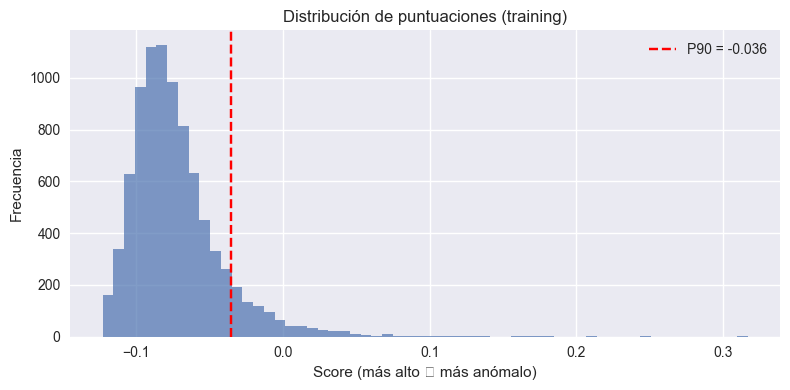

In [6]:
# 6 · Histograma de puntuaciones (training)
X_feats = detector._build_features(train_df)
scores  = -detector.pipeline_.decision_function(X_feats)
thr     = detector.score_threshold_

plt.figure(figsize=(8, 4))
plt.hist(scores, bins=60, alpha=0.7)
plt.axvline(thr, color="red", linestyle="--", label=f"P90 = {thr:.3f}")
plt.title("Distribución de puntuaciones (training)")
plt.xlabel("Score (más alto ⇒ más anómalo)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
example = pd.DataFrame(
    {
        "water_meter_id": [train_df["water_meter_id"].iloc[0]],
        "total_consumed": [150],
        "days_billed":   [30],
        "period_start":  [datetime.now()],
        "neighborhood_id": ["X"],
    }
)
print("\nPredicción ejemplo:", detector.predict(example))


Predicción ejemplo: {'anomaly': [True], 'score': [0.0005579875074035456], 'confidence': [0.0]}
